今天来学习无监督算法中的聚类，常利用聚类来发现数据中的模式，并对每一个聚类后的类别特征进行可视化，以此得到新的特征——赋予实际含义。

# 一、前置工作

In [1]:
import pandas as  pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data=pd.read_csv('heart.csv')

# 医学特征中英文映射字典
medical_feature_map = {
    "age": "年龄",
    "sex": "性别",
    "cp": "胸痛类型",
    "trestbps": "静息血压",  # 单位：mm Hg（毫米汞柱）
    "chol": "血清胆固醇浓度",  # 单位：mg/dl（毫克/分升）
    "fbs": "空腹血糖",  # 单位：mg/dl，通常以120mg/dl为分界，大于120mg/dl为1
    "restecg": "静息心电图结果",
    "thalach": "最大心率",
    "exang": "运动诱发心绞痛",
    "oldpeak": "运动相对静息的ST段压低",  # 单位：mV（毫伏）
    "slope": "ST段峰值斜率",
    "ca": "荧光检查显示的主要血管数量",  # 0-3支
    "thal": "地中海贫血症状态",
    "target": "患病目标变量"  # 通常1=患病，0=正常
}

data = data.rename(columns=medical_feature_map)
data.head()

,年龄,性别,胸痛类型,静息血压,血清胆固醇浓度,空腹血糖,静息心电图结果,最大心率,运动诱发心绞痛,运动相对静息的ST段压低,ST段峰值斜率,荧光检查显示的主要血管数量,地中海贫血症状态,患病目标变量
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
data.columns

Index(['年龄', '性别', '胸痛类型', '静息血压', '血清胆固醇浓度', '空腹血糖', '静息心电图结果', '最大心率',
       '运动诱发心绞痛', '运动相对静息的ST段压低', 'ST段峰值斜率', '荧光检查显示的主要血管数量', '地中海贫血症状态',
       '患病目标变量'],
      dtype='object')

In [3]:
from sklearn.model_selection import train_test_split
X=data.drop(['患病目标变量'], axis=1)
y=data['患病目标变量']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'训练集形状：{X_train.shape}, 测试集形状：{X_test.shape}')

训练集形状：(242, 13), 测试集形状：(61, 13)


In [9]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

continuous_features=['年龄', '静息血压', '血清胆固醇浓度', '最大心率', '运动相对静息的ST段压低']

min_max_scaler = MinMaxScaler()

# 仅在训练集上 fit (学习最大值和最小值)
# 然后对训练集进行 transform (应用缩放)
# 注意：Scikit-learn 返回 NumPy 数组，需要重新赋值给 DataFrame
X_train[continuous_features]=min_max_scaler.fit_transform(X_train[continuous_features])

# 使用训练集学到的参数 (scaler) 直接对测试集进行 transform
# 绝对不能对测试集使用 fit_transform()
X_test[continuous_features] = min_max_scaler.transform(X_test[continuous_features])
X_test

,年龄,性别,胸痛类型,静息血压,血清胆固醇浓度,空腹血糖,静息心电图结果,最大心率,运动诱发心绞痛,运动相对静息的ST段压低,ST段峰值斜率,荧光检查显示的主要血管数量,地中海贫血症状态
179,0.583333,1,0,0.571429,0.334873,0,0,0.210526,1,0.107143,1,1,1
228,0.625000,1,3,0.775510,0.362587,0,0,0.622807,0,0.035714,1,0,3
111,0.583333,1,2,0.571429,-0.011547,1,1,0.745614,0,0.035714,2,1,3
246,0.562500,0,0,0.408163,0.642032,0,0,0.543860,1,0.339286,1,2,3
60,0.875000,0,2,0.163265,0.309469,1,0,0.368421,0,0.000000,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,0.833333,1,2,0.469388,0.284065,0,0,0.508772,0,0.357143,1,3,3
104,0.437500,1,2,0.357143,0.150115,0,1,0.657895,0,0.000000,2,0,2
300,0.812500,1,0,0.510204,0.143187,1,1,0.464912,0,0.607143,1,2,3
193,0.645833,1,0,0.520408,0.348730,0,0,0.473684,1,0.500000,1,2,3


# 二、聚类评估指标介绍

以下是三种常用的聚类效果评估指标，分别用于衡量聚类的质量和簇的分离与紧凑程度：

### 1. 轮廓系数 (Silhouette Score)
- **定义**：轮廓系数衡量每个样本与其所属簇的紧密程度以及与最近其他簇的分离程度。
- **取值范围**：[-1, 1]
  - 轮廓系数越接近 **1**，表示样本与其所属簇内其他样本很近，与其他簇很远，聚类效果越好。
  - 轮廓系数越接近 **-1**，表示样本与其所属簇内样本较远，与其他簇较近，聚类效果越差（可能被错误分类）。
  - 轮廓系数接近 **0**，表示样本在簇边界附近，聚类效果无明显好坏。
- **使用建议**：选择轮廓系数最高的 `k` 值作为最佳簇数量。

### 2. CH 指数 (Calinski-Harabasz Index)
- **定义**：CH 指数是簇间分散度与簇内分散度之比，用于评估簇的分离度和紧凑度。
- **取值范围**：[0, +∞)
  - CH 指数越大，表示簇间分离度越高，簇内紧凑度越高，聚类效果越好。
  - 没有固定的上限，值越大越好。
- **使用建议**：选择 CH 指数最高的 `k` 值作为最佳簇数量。

### 3. DB 指数 (Davies-Bouldin Index)
- **定义**：DB 指数衡量簇间距离与簇内分散度的比值，用于评估簇的分离度和紧凑度。
- **取值范围**：[0, +∞)
  - DB 指数越小，表示簇间分离度越高，簇内紧凑度越高，聚类效果越好。
  - 没有固定的上限，值越小越好。
- **使用建议**：选择 DB 指数最低的 `k` 值作为最佳簇数量。





# 三、KMeans 聚类

### 算法原理
KMeans 是一种基于距离的聚类算法，需要预先指定聚类个数，即 `k`。其核心步骤如下：
1. 随机选择 `k` 个样本点作为初始质心（簇中心）。
2. 计算每个样本点到各个质心的距离，将样本点分配到距离最近的质心所在的簇。
3. 更新每个簇的质心为该簇内所有样本点的均值。
4. 重复步骤 2 和 3，直到质心不再变化或达到最大迭代次数为止。

### 确定簇数的方法：肘部法
- **肘部法（Elbow Method）** 是一种常用的确定 `k` 值的方法。
- 原理：通过计算不同 `k` 值下的簇内平方和（Within-Cluster Sum of Squares, WCSS），绘制 `k` 与 WCSS 的关系图。
- 选择标准：在图中找到“肘部”点，即 WCSS 下降速率明显减缓的 `k` 值，通常认为是最佳簇数。这是因为增加 `k` 值带来的收益（WCSS 减少）在该点后变得不显著。

### KMeans 算法的优缺点
#### 优点
- **简单高效**：算法实现简单，计算速度快，适合处理大规模数据集。
- **适用性强**：对球形或紧凑的簇效果较好，适用于特征空间中簇分布较为均匀的数据。
- **易于解释**：聚类结果直观，簇中心具有明确的物理意义。

#### 缺点
- **需预先指定 `k` 值**：对簇数量 `k` 的选择敏感，不合适的 `k` 会导致聚类效果较差。
- **对初始质心敏感**：初始质心的随机选择可能导致结果不稳定或陷入局部最优（可通过 KMeans++ 初始化方法缓解）。
- **对噪声和异常值敏感**：异常值可能会显著影响质心的位置，导致聚类结果失真。
- **不适合非球形簇**：对非线性可分或形状复杂的簇效果较差，无法处理簇密度不均的情况。


k=2, 惯性: 669.33, 轮廓系数: 0.241, CH 指数: 83.47, DB 指数: 1.626
k=3, 惯性: 535.18, 轮廓系数: 0.243, CH 指数: 81.93, DB 指数: 1.426
k=4, 惯性: 483.65, 轮廓系数: 0.179, CH 指数: 68.64, DB 指数: 1.661
k=5, 惯性: 458.46, 轮廓系数: 0.179, CH 指数: 57.34, DB 指数: 1.609
k=6, 惯性: 439.28, 轮廓系数: 0.157, CH 指数: 49.73, DB 指数: 1.775
k=7, 惯性: 406.04, 轮廓系数: 0.166, CH 指数: 47.85, DB 指数: 1.802
k=8, 惯性: 376.09, 轮廓系数: 0.177, CH 指数: 46.76, DB 指数: 1.646
k=9, 惯性: 364.37, 轮廓系数: 0.160, CH 指数: 42.98, DB 指数: 1.659
k=10, 惯性: 353.73, 轮廓系数: 0.157, CH 指数: 39.96, DB 指数: 1.644


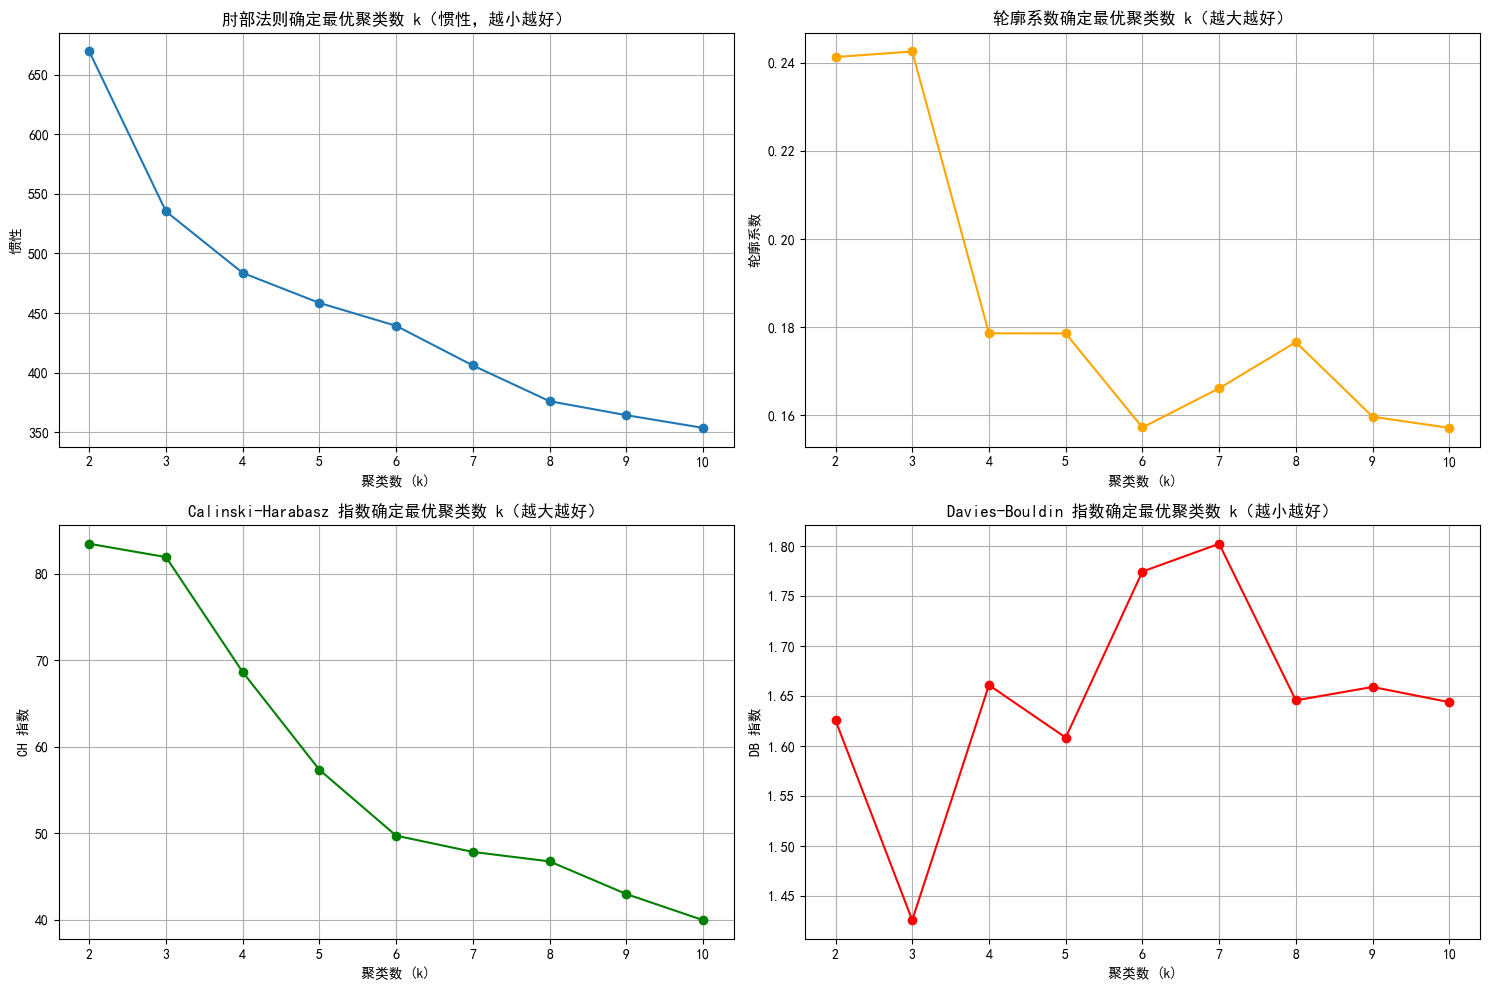

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 评估不同 k 值下的指标
k_range = range(2, 11)  # 测试 k 从 2 到 10
inertia_values = []
silhouette_scores = []
ch_scores = []
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_train)
    inertia_values.append(kmeans.inertia_)  # 惯性（肘部法则）
    silhouette = silhouette_score(X_train, kmeans_labels)  # 轮廓系数
    silhouette_scores.append(silhouette)
    ch = calinski_harabasz_score(X_train, kmeans_labels)  # CH 指数
    ch_scores.append(ch)
    db = davies_bouldin_score(X_train, kmeans_labels)  # DB 指数
    db_scores.append(db)
    print(f"k={k}, 惯性: {kmeans.inertia_:.2f}, 轮廓系数: {silhouette:.3f}, CH 指数: {ch:.2f}, DB 指数: {db:.3f}")

# 绘制评估指标图
plt.figure(figsize=(15, 10))

# 肘部法则图（Inertia）
plt.subplot(2, 2, 1)
plt.plot(k_range, inertia_values, marker='o')
plt.title('肘部法则确定最优聚类数 k（惯性，越小越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('惯性')
plt.grid(True)

# 轮廓系数图
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('轮廓系数确定最优聚类数 k（越大越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('轮廓系数')
plt.grid(True)

# CH 指数图
plt.subplot(2, 2, 3)
plt.plot(k_range, ch_scores, marker='o', color='green')
plt.title('Calinski-Harabasz 指数确定最优聚类数 k（越大越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('CH 指数')
plt.grid(True)

# DB 指数图
plt.subplot(2, 2, 4)
plt.plot(k_range, db_scores, marker='o', color='red')
plt.title('Davies-Bouldin 指数确定最优聚类数 k（越小越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('DB 指数')
plt.grid(True)

plt.tight_layout()
plt.show()

看图：
1. 肘部法则图： 找下降速率变慢的拐点，这里整体都在变慢
2. 轮廓系数图：找局部最高点，这里选3或8
3. CH指数图： 找局部最高点，这里选6之前的
4. DB指数图：找局部最低点，这里选3 5 7都行

综上，选择3比较合适。

- 为什么选择局部最优的点，因为比如簇间差异，分得越细越好，但是k太细了没价值，所以要有取舍。不能无限制增大 k，要防止过拟合，因此要在图上选一个“最优拐点”
- 当多个候选 k 都合理时，可以选更大的 k（但仍然在合理范围内）。比如k可以选3和5，推荐选择5，能包含更多信息。


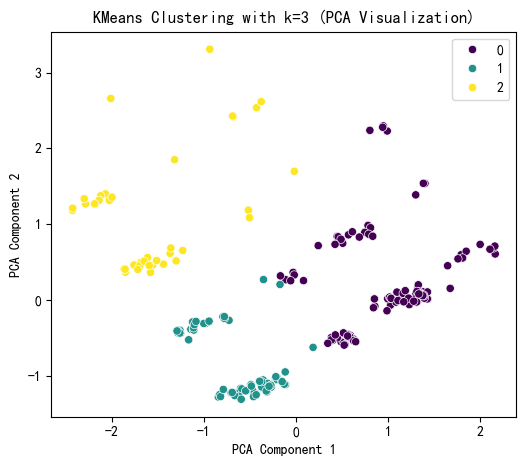

KMeans_Cluster
0    118
1     83
2     41
Name: count, dtype: int64


In [14]:
selected_k = 3

kmeans = KMeans(n_clusters=selected_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train)

# 只在 X_train 上加列
X_train = X_train.copy()
X_train['KMeans_Cluster'] = kmeans_labels

# PCA 可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.drop(columns=['KMeans_Cluster']))

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title(f'KMeans Clustering with k={selected_k} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

print(X_train['KMeans_Cluster'].value_counts())


## DBSCAN聚类

In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns



# 评估不同 eps 和 min_samples 下的指标
# eps这个参数表示邻域的半径，min_samples表示一个点被认为是核心点所需的最小样本数。
# min_samples这个参数表示一个核心点所需的最小样本数。

eps_range = np.arange(0.3, 0.8, 0.1)  # 测试 eps 从 0.3 到 0.7
min_samples_range = range(3, 8)  # 测试 min_samples 从 3 到 7
results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_train)
        # 计算簇的数量（排除噪声点 -1）
        n_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        # 计算噪声点数量
        n_noise = list(dbscan_labels).count(-1)
        # 只有当簇数量大于 1 且有有效簇时才计算评估指标
        if n_clusters > 1:
            # 排除噪声点后计算评估指标
            mask = dbscan_labels != -1
            if mask.sum() > 0:  # 确保有非噪声点
                silhouette = silhouette_score(X_train[mask], dbscan_labels[mask])
                ch = calinski_harabasz_score(X_train[mask], dbscan_labels[mask])
                db = davies_bouldin_score(X_train[mask], dbscan_labels[mask])
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': silhouette,
                    'ch_score': ch,
                    'db_score': db
                })
                print(f"eps={eps:.1f}, min_samples={min_samples}, 簇数: {n_clusters}, 噪声点: {n_noise}, "
                      f"轮廓系数: {silhouette:.3f}, CH 指数: {ch:.2f}, DB 指数: {db:.3f}")
        else:
            print(f"eps={eps:.1f}, min_samples={min_samples}, 簇数: {n_clusters}, 噪声点: {n_noise}, 无法计算评估指标")

# 将结果转为 DataFrame 以便可视化和选择参数
results_df = pd.DataFrame(results)

eps=0.3, min_samples=3, 簇数: 8, 噪声点: 208, 轮廓系数: 0.786, CH 指数: 282.80, DB 指数: 0.251
eps=0.3, min_samples=4, 簇数: 3, 噪声点: 224, 轮廓系数: 0.747, CH 指数: 130.60, DB 指数: 0.312
eps=0.3, min_samples=5, 簇数: 3, 噪声点: 224, 轮廓系数: 0.747, CH 指数: 130.60, DB 指数: 0.312
eps=0.3, min_samples=6, 簇数: 1, 噪声点: 234, 无法计算评估指标
eps=0.3, min_samples=7, 簇数: 1, 噪声点: 234, 无法计算评估指标
eps=0.4, min_samples=3, 簇数: 14, 噪声点: 188, 轮廓系数: 0.722, CH 指数: 190.89, DB 指数: 0.350
eps=0.4, min_samples=4, 簇数: 4, 噪声点: 218, 轮廓系数: 0.742, CH 指数: 121.89, DB 指数: 0.341
eps=0.4, min_samples=5, 簇数: 3, 噪声点: 222, 轮廓系数: 0.729, CH 指数: 121.85, DB 指数: 0.366
eps=0.4, min_samples=6, 簇数: 3, 噪声点: 222, 轮廓系数: 0.729, CH 指数: 121.85, DB 指数: 0.366
eps=0.4, min_samples=7, 簇数: 1, 噪声点: 234, 无法计算评估指标
eps=0.5, min_samples=3, 簇数: 16, 噪声点: 173, 轮廓系数: 0.664, CH 指数: 137.08, DB 指数: 0.469
eps=0.5, min_samples=4, 簇数: 8, 噪声点: 198, 轮廓系数: 0.688, CH 指数: 146.46, DB 指数: 0.433
eps=0.5, min_samples=5, 簇数: 5, 噪声点: 211, 轮廓系数: 0.734, CH 指数: 185.15, DB 指数: 0.351
eps=0.5, min_samples=6, 簇数: 

In [16]:
results_df

,eps,min_samples,n_clusters,n_noise,silhouette,ch_score,db_score
0,0.3,3,8,208,0.786062,282.804174,0.250771
1,0.3,4,3,224,0.747248,130.602406,0.311601
2,0.3,5,3,224,0.747248,130.602406,0.311601
3,0.4,3,14,188,0.722192,190.893438,0.349712
4,0.4,4,4,218,0.741810,121.889730,0.340980
5,0.4,5,3,222,0.728703,121.850905,0.366171
6,0.4,6,3,222,0.728703,121.850905,0.366171
7,0.5,3,16,173,0.663858,137.079933,0.469151
8,0.5,4,8,198,0.688307,146.455806,0.432730
9,0.5,5,5,211,0.734053,185.154649,0.351395


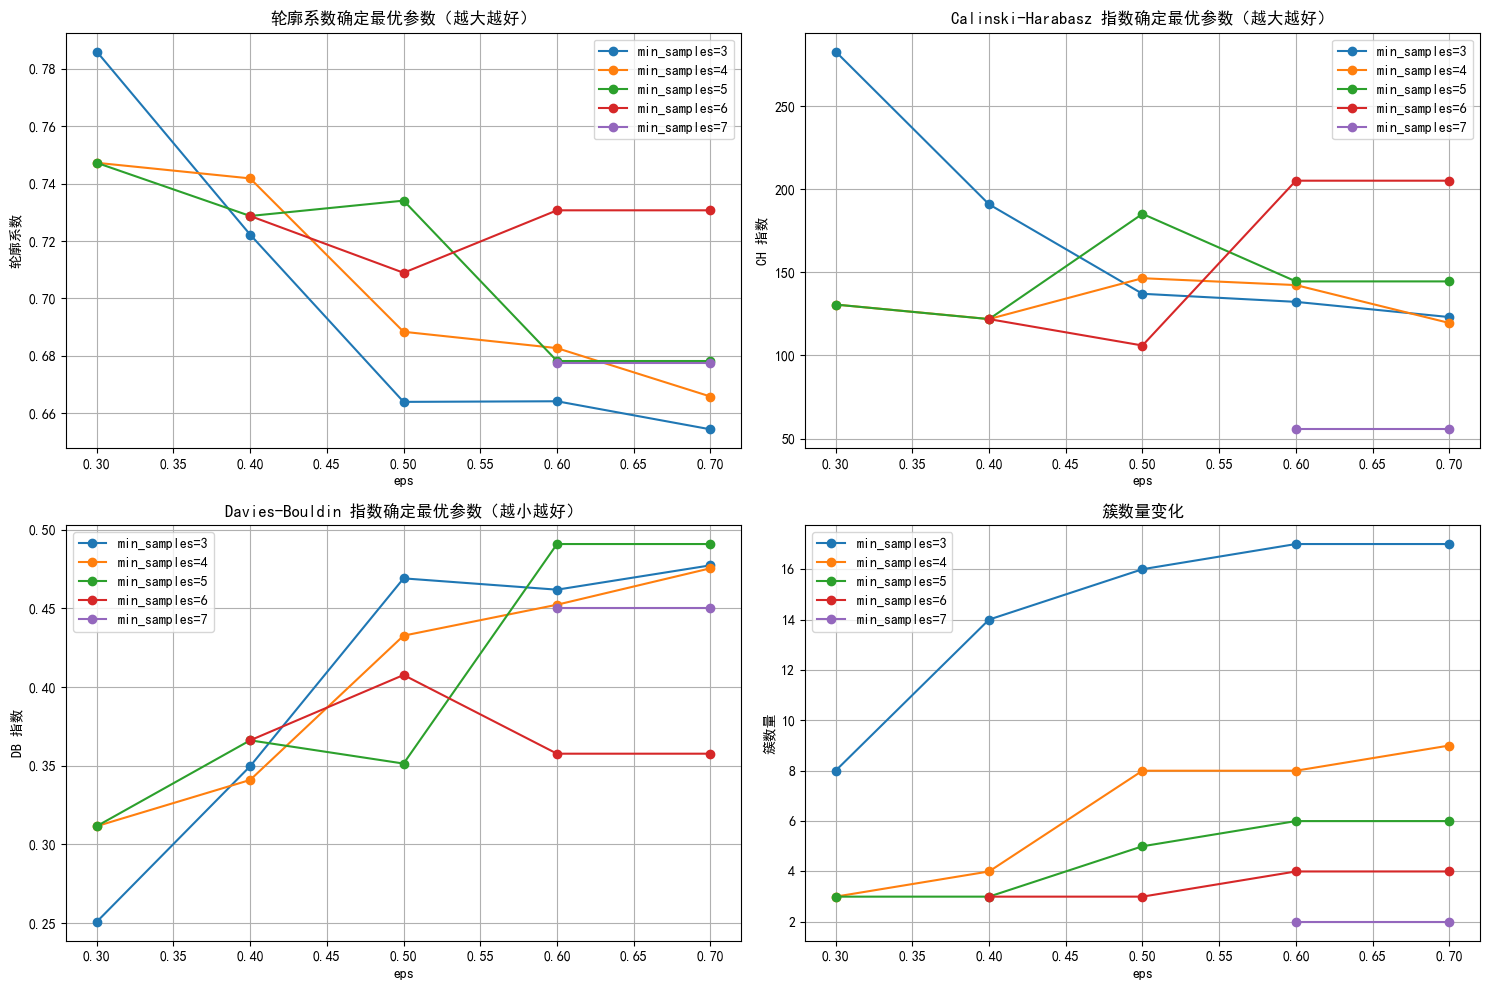

In [17]:
# 绘制评估指标图，增加点论文中的工作量
plt.figure(figsize=(15, 10))
# 轮廓系数图
plt.subplot(2, 2, 1)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples] # 
    plt.plot(subset['eps'], subset['silhouette'], marker='o', label=f'min_samples={min_samples}')
plt.title('轮廓系数确定最优参数（越大越好）')
plt.xlabel('eps')
plt.ylabel('轮廓系数')
plt.legend()
plt.grid(True)

# CH 指数图
plt.subplot(2, 2, 2)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['ch_score'], marker='o', label=f'min_samples={min_samples}')
plt.title('Calinski-Harabasz 指数确定最优参数（越大越好）')
plt.xlabel('eps')
plt.ylabel('CH 指数')
plt.legend()
plt.grid(True)

# DB 指数图
plt.subplot(2, 2, 3)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['db_score'], marker='o', label=f'min_samples={min_samples}')
plt.title('Davies-Bouldin 指数确定最优参数（越小越好）')
plt.xlabel('eps')
plt.ylabel('DB 指数')
plt.legend()
plt.grid(True)

# 簇数量图
plt.subplot(2, 2, 4)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['n_clusters'], marker='o', label=f'min_samples={min_samples}')
plt.title('簇数量变化')
plt.xlabel('eps')
plt.ylabel('簇数量')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


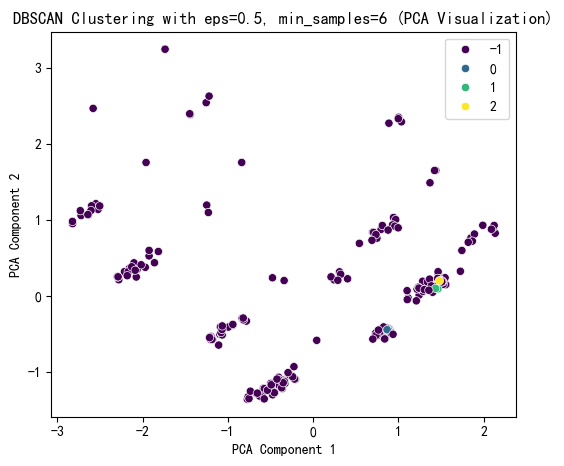

DBSCAN Cluster label counts in X_train:
DBSCAN_Cluster
-1    221
 0      8
 2      7
 1      6
Name: count, dtype: int64


In [20]:
selected_eps = 0.5
selected_min_samples = 6

dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_samples)
dbscan_labels = dbscan.fit_predict(X_train)

# 在 X_train 上加列
X_train = X_train.copy()
X_train['DBSCAN_Cluster'] = dbscan_labels

# PCA 可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.drop(columns=['DBSCAN_Cluster']))

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='viridis')
plt.title(f'DBSCAN Clustering with eps={selected_eps}, min_samples={selected_min_samples} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

print("DBSCAN Cluster label counts in X_train:")
print(X_train['DBSCAN_Cluster'].value_counts())


DBSCAN 聚类效果不好，因为几乎所有点都被分到一个簇里，少数簇数量太少；也说明 DBSCAN 本身可能不适合这类数据

## 层次聚类

Agglomerative Clustering 是一种自底向上的层次聚类方法，初始时每个样本是一个簇，然后逐步合并最相似的簇，直到达到指定的簇数量或满足停止条件。由于它需要指定簇数量（类似于 KMeans），我将通过测试不同的簇数量 n_clusters 来评估聚类效果，并使用轮廓系数（Silhouette Score）、CH 指数（Calinski-Harabasz Index）和 DB 指数（Davies-Bouldin Index）作为评估指标。

n_clusters=2, 轮廓系数: 0.133, CH 指数: 38.71, DB 指数: 2.564
n_clusters=3, 轮廓系数: 0.097, CH 指数: 32.44, DB 指数: 2.558
n_clusters=4, 轮廓系数: 0.104, CH 指数: 31.10, DB 指数: 2.194
n_clusters=5, 轮廓系数: 0.104, CH 指数: 27.60, DB 指数: 2.567
n_clusters=6, 轮廓系数: 0.113, CH 指数: 25.59, DB 指数: 2.265
n_clusters=7, 轮廓系数: 0.097, CH 指数: 23.90, DB 指数: 2.230
n_clusters=8, 轮廓系数: 0.100, CH 指数: 22.85, DB 指数: 2.281
n_clusters=9, 轮廓系数: 0.107, CH 指数: 21.78, DB 指数: 2.195
n_clusters=10, 轮廓系数: 0.111, CH 指数: 20.81, DB 指数: 2.120


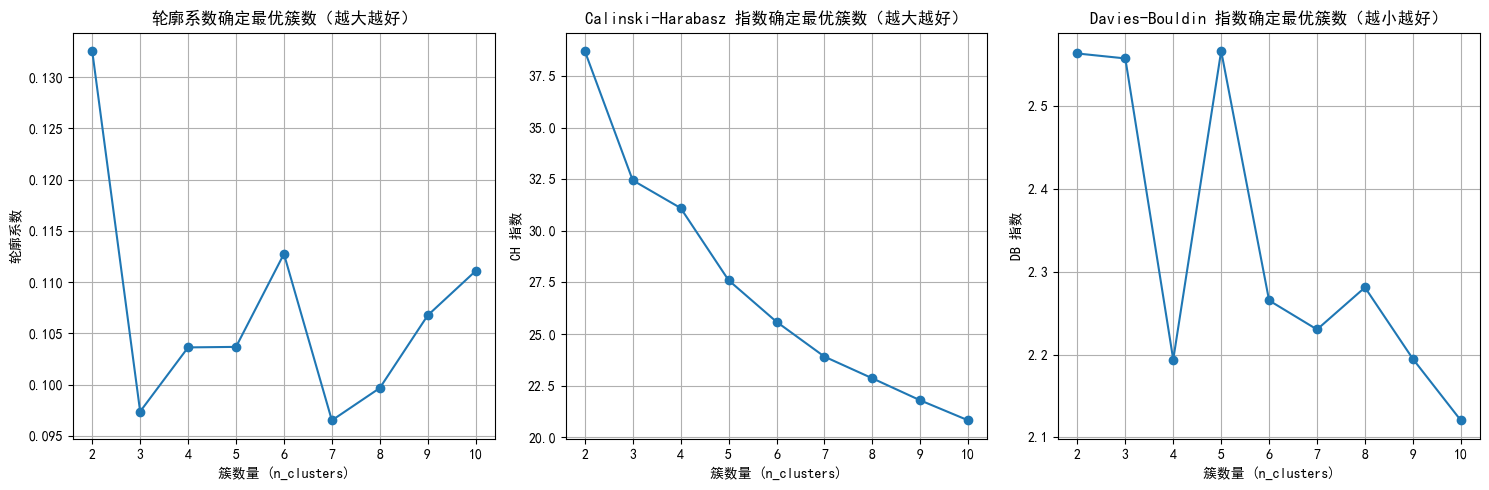

In [22]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 标准化数据
scaler = StandardScaler()
X_train = scaler.fit_transform(X)

# 评估不同 n_clusters 下的指标
n_clusters_range = range(2, 11)  # 测试簇数量从 2 到 10
silhouette_scores = []
ch_scores = []
db_scores = []

for n_clusters in n_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # 使用 Ward 准则合并簇
    agglo_labels = agglo.fit_predict(X_train)
    
    # 计算评估指标
    silhouette = silhouette_score(X_train, agglo_labels)
    ch = calinski_harabasz_score(X_train, agglo_labels)
    db = davies_bouldin_score(X_train, agglo_labels)
    
    silhouette_scores.append(silhouette)
    ch_scores.append(ch)
    db_scores.append(db)
    
    print(f"n_clusters={n_clusters}, 轮廓系数: {silhouette:.3f}, CH 指数: {ch:.2f}, DB 指数: {db:.3f}")

# 绘制评估指标图
plt.figure(figsize=(15, 5))

# 轮廓系数图
plt.subplot(1, 3, 1)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('轮廓系数确定最优簇数（越大越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('轮廓系数')
plt.grid(True)

# CH 指数图
plt.subplot(1, 3, 2)
plt.plot(n_clusters_range, ch_scores, marker='o')
plt.title('Calinski-Harabasz 指数确定最优簇数（越大越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('CH 指数')
plt.grid(True)

# DB 指数图
plt.subplot(1, 3, 3)
plt.plot(n_clusters_range, db_scores, marker='o')
plt.title('Davies-Bouldin 指数确定最优簇数（越小越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('DB 指数')
plt.grid(True)

plt.tight_layout()
plt.show()

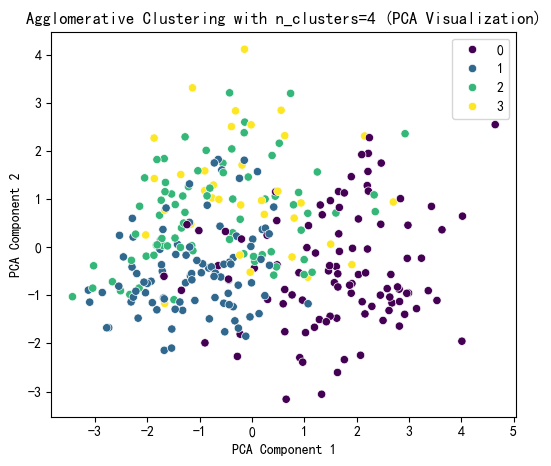

Agglomerative Cluster labels (n_clusters=4) added to X:
Agglo_Cluster
0                100
1                 92
2                 77
3                 34
Name: count, dtype: int64


In [27]:
# 提示用户选择 n_clusters 值（这里可以根据图表选择最佳簇数）
selected_n_clusters = 4  # 示例值，根据图表调整

# 使用选择的簇数进行 Agglomerative Clustering 聚类
agglo = AgglomerativeClustering(n_clusters=selected_n_clusters, linkage='ward')
agglo_labels = agglo.fit_predict(X_train)
X['Agglo_Cluster'] = agglo_labels

# 使用 PCA 降维到 2D 进行可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Agglomerative Clustering 聚类结果可视化
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette='viridis')
plt.title(f'Agglomerative Clustering with n_clusters={selected_n_clusters} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 打印 Agglomerative Clustering 聚类标签的分布
print(f"Agglomerative Cluster labels (n_clusters={selected_n_clusters}) added to X:")
print(X[['Agglo_Cluster']].value_counts())

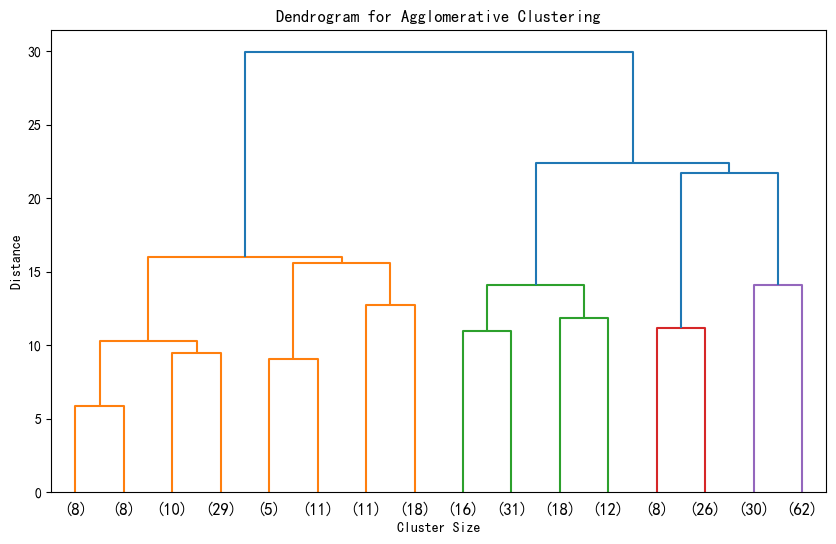

In [24]:
# 层次聚类的树状图可视化
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# 假设 X_scaled 是标准化后的数据
# 计算层次聚类的链接矩阵
Z = hierarchy.linkage(X_train, method='ward')  # 'ward' 是常用的合并准则

# 绘制树状图
plt.figure(figsize=(10, 6))
hierarchy.dendrogram(Z, truncate_mode='level', p=3)  # p 控制显示的层次深度
# hierarchy.dendrogram(Z, truncate_mode='level')  # 不用p这个参数，可以显示全部的深度
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


1. 横坐标代表每个簇对应样本的数据，这些样本数目加一起是整个数据集的样本数目。这是从上到下进行截断，p=3显示最后3层，不用p这个参数会显示全部。
2. 纵轴代表距离 ，反映了在聚类过程中，不同样本或簇合并时的距离度量值。距离越大，意味着两个样本或簇之间的差异越大；距离越小，则差异越小。